# cell 1 - importing 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set environment for high-quality visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100 # High resolution for plots

# --- Load Data ---
# ACTION: Update 'your_data_file.csv' and the separator ('|' or ',')
FILE_PATH = '../data/MachineLearningRating_v3.txt'
df = pd.read_csv(FILE_PATH, sep='|') 

# --- Cleaning and Type Conversion ---
df = df.replace(' ', np.nan) # Replace empty spaces with NaN
financial_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CustomValueEstimate']

# Convert date column and financial columns
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth']).dt.to_period('M')
for col in financial_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

# Clean up 'Not specified' and NaN values in key categorical columns
for col in ['Citizenship', 'MaritalStatus', 'Gender', 'Province']:
    df[col] = df[col].replace({'Not specified': 'Unknown', np.nan: 'Unknown'}).str.strip()

print("--- Data Structure Review ---")
print(df.info())
print("\n--- Missing Value Summary ---")
print(df.isnull().sum()[df.isnull().sum() > 0].to_markdown())

C:\Users\hp\AppData\Local\Temp\ipykernel_5052\3235220584.py:14: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE_PATH, sep='|')


--- Data Structure Review ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype    
---  ------                    --------------    -----    
 0   UnderwrittenCoverID       1000098 non-null  int64    
 1   PolicyID                  1000098 non-null  int64    
 2   TransactionMonth          1000098 non-null  period[M]
 3   IsVATRegistered           1000098 non-null  bool     
 4   Citizenship               1000098 non-null  object   
 5   LegalType                 1000098 non-null  object   
 6   Title                     1000098 non-null  object   
 7   Language                  1000098 non-null  object   
 8   Bank                      854137 non-null   object   
 9   AccountType               959866 non-null   object   
 10  MaritalStatus             1000098 non-null  object   
 11  Gender                    1000098 non-null  object   
 12  Country                   

# 2. Data Summarization and Univariate Analysis


--- Descriptive Statistics and Variability (Financial Columns) ---
|                     |      count |      mean |        std |    CV |         max |
|:--------------------|-----------:|----------:|-----------:|------:|------------:|
| TotalPremium        | 1000098.00 |     61.91 |     230.28 |  3.72 |    65282.60 |
| TotalClaims         | 1000098.00 |     64.86 |    2384.07 | 36.76 |   393092.11 |
| SumInsured          | 1000098.00 | 604172.73 | 1508331.84 |  2.50 | 12636200.00 |
| CustomValueEstimate |  220456.00 | 225531.13 |  564515.75 |  2.50 | 26550000.00 |

Overall Portfolio Loss Ratio: 1.0477


c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


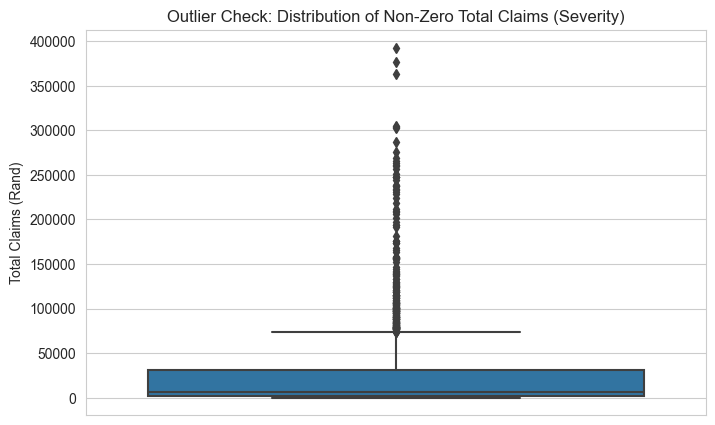

'Expected shape: highly skewed with many outliers'

In [5]:
# 2.1 Descriptive Statistics (KPI: Demonstrate Stats Understanding)
print("\n--- Descriptive Statistics and Variability (Financial Columns) ---")
desc_stats = df[financial_cols].describe().T
desc_stats['CV'] = desc_stats['std'] / desc_stats['mean']
print(desc_stats[['count', 'mean', 'std', 'CV', 'max']].to_markdown(floatfmt=".2f"))

# 2.2 Overall Loss Ratio (Guiding Question: Overall LR)
overall_total_premium = df['TotalPremium'].sum()
overall_total_claims = df['TotalClaims'].sum()
overall_loss_ratio = overall_total_claims / overall_total_premium
print(f"\nOverall Portfolio Loss Ratio: {overall_loss_ratio:.4f}")

# 2.3 Outlier Detection (Guiding Question: Are there outliers?)
plt.figure(figsize=(8, 5))
# Plotting only positive claims to visualize the severity distribution
sns.boxplot(y=df[df['TotalClaims'] > 0]['TotalClaims']) 
plt.title('Outlier Check: Distribution of Non-Zero Total Claims (Severity)')
plt.ylabel('Total Claims (Rand)')
plt.show() # 

["Image of a box plot with numerous outliers"]
("Expected shape: highly skewed with many outliers")

# 3. Bivariate Analysis and Visualization

c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


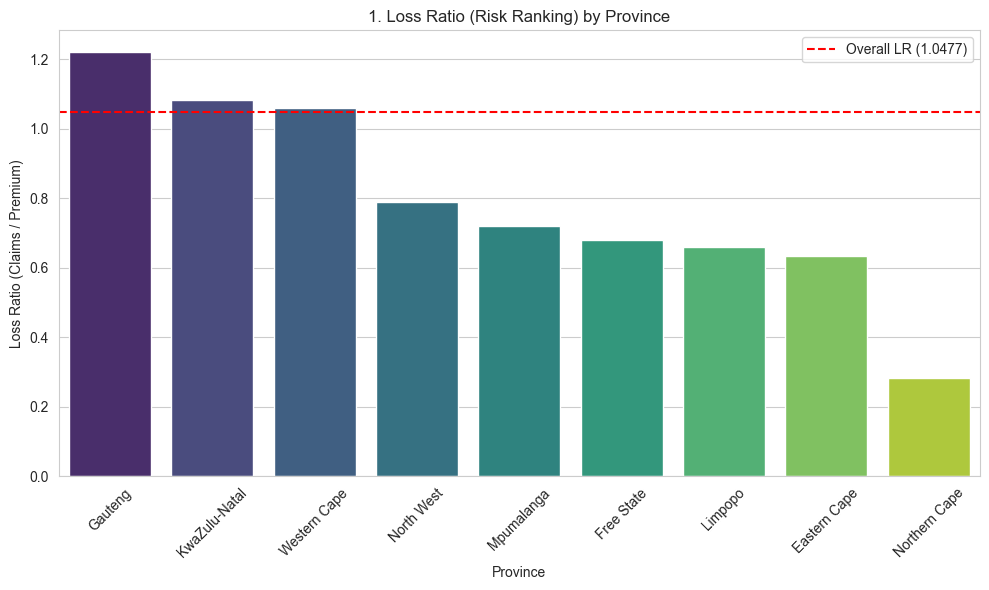

In [6]:
# Aggregate data by Province
province_risk = df.groupby('Province').agg(
    TotalPremium=('TotalPremium', 'sum'),
    TotalClaims=('TotalClaims', 'sum')
)
# Filter for stable metrics (ignore "Unknown" and low-volume provinces)
province_risk = province_risk[province_risk.index != 'Unknown']
province_risk = province_risk[province_risk['TotalPremium'] > 10000].copy() 

province_risk['Loss_Ratio'] = province_risk['TotalClaims'] / province_risk['TotalPremium']
province_risk = province_risk.sort_values('Loss_Ratio', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=province_risk.index, y=province_risk['Loss_Ratio'], palette="viridis")
plt.axhline(overall_loss_ratio, color='r', linestyle='--', label=f'Overall LR ({overall_loss_ratio:.4f})')
plt.title('1. Loss Ratio (Risk Ranking) by Province')
plt.xlabel('Province')
plt.ylabel('Loss Ratio (Claims / Premium)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot 2: Vehicle Makes by Average Claim Severity

c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


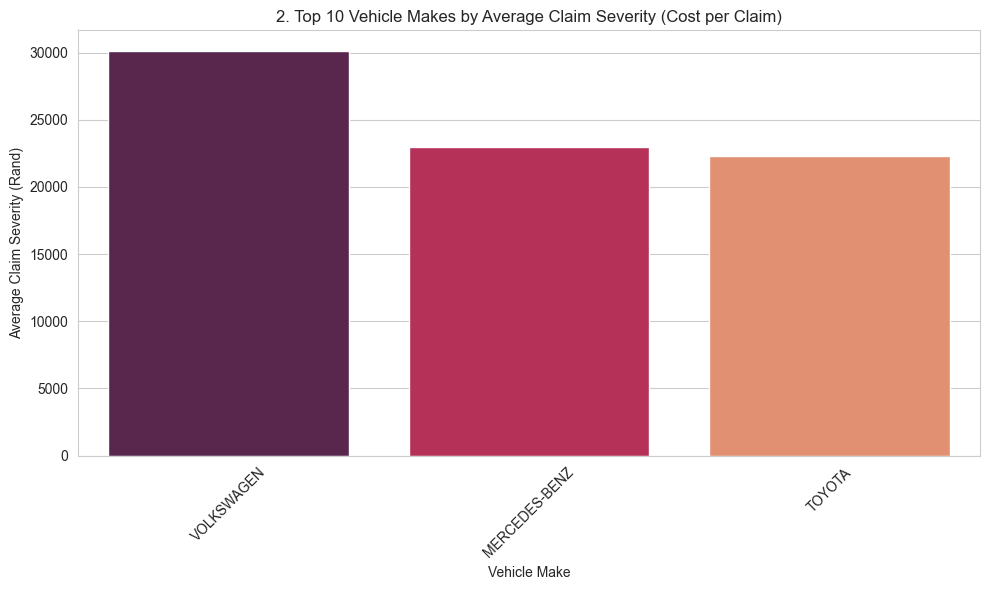

In [7]:
# Aggregate by Vehicle Make, focusing on claim severity
make_risk = df.groupby('make').agg(
    TotalClaims=('TotalClaims', 'sum'),
    Claim_Count=('TotalClaims', lambda x: (x > 0).sum())
).reset_index()

# Filter for makes with a stable claim history (e.g., at least 50 claims)
make_risk = make_risk[make_risk['Claim_Count'] >= 50].copy() 

make_risk['Avg_Claim_Severity'] = np.where(make_risk['Claim_Count'] > 0, 
                                            make_risk['TotalClaims'] / make_risk['Claim_Count'], 0)
make_risk = make_risk.sort_values('Avg_Claim_Severity', ascending=False)

plt.figure(figsize=(10, 6))
# Plot top 10 makes by severity
sns.barplot(x='make', y='Avg_Claim_Severity', data=make_risk.head(10), palette="rocket")
plt.title('2. Top 10 Vehicle Makes by Average Claim Severity (Cost per Claim)')
plt.xlabel('Vehicle Make')
plt.ylabel('Average Claim Severity (Rand)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Monthly Loss Ratio Trend

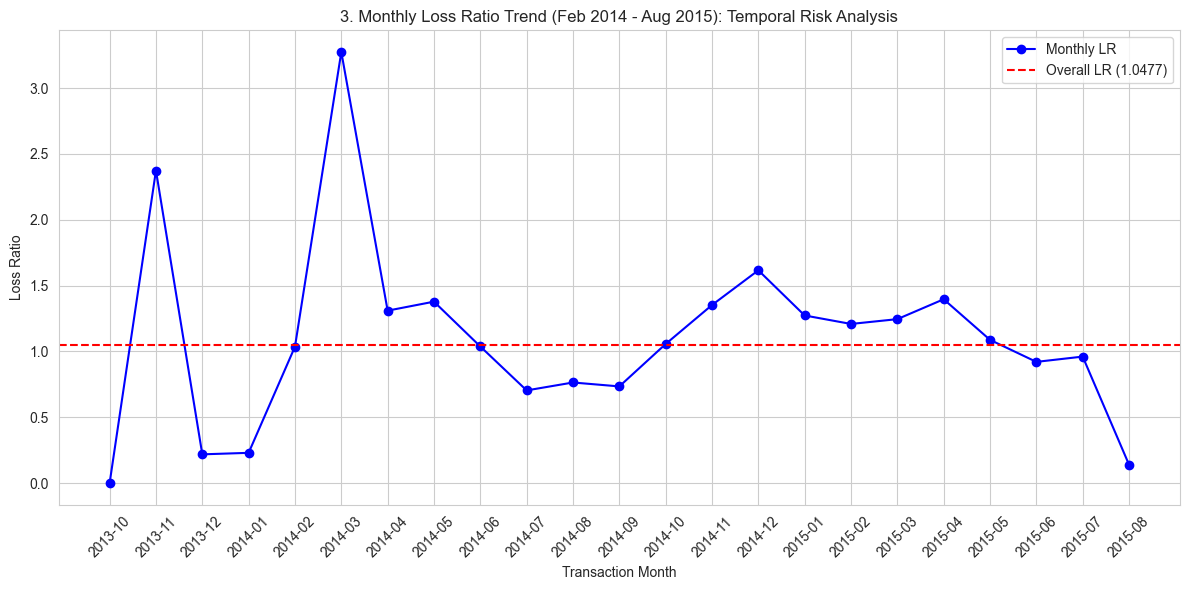

In [8]:
# Aggregate data by TransactionMonth
monthly_trend = df.groupby('TransactionMonth').agg(
    TotalPremium=('TotalPremium', 'sum'),
    TotalClaims=('TotalClaims', 'sum'),
).reset_index()

monthly_trend['Loss_Ratio'] = monthly_trend['TotalClaims'] / monthly_trend['TotalPremium']
monthly_trend = monthly_trend[monthly_trend['TotalPremium'] > 0] 

plt.figure(figsize=(12, 6))
# Convert period to string for plotting on the x-axis
plt.plot(monthly_trend['TransactionMonth'].astype(str), monthly_trend['Loss_Ratio'], 
         marker='o', linestyle='-', color='b', label='Monthly LR')
plt.axhline(overall_loss_ratio, color='r', linestyle='--', label=f'Overall LR ({overall_loss_ratio:.4f})')
plt.title('3. Monthly Loss Ratio Trend (Feb 2014 - Aug 2015): Temporal Risk Analysis')
plt.xlabel('Transaction Month')
plt.ylabel('Loss Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Province x VehicleType Risk Heatmap

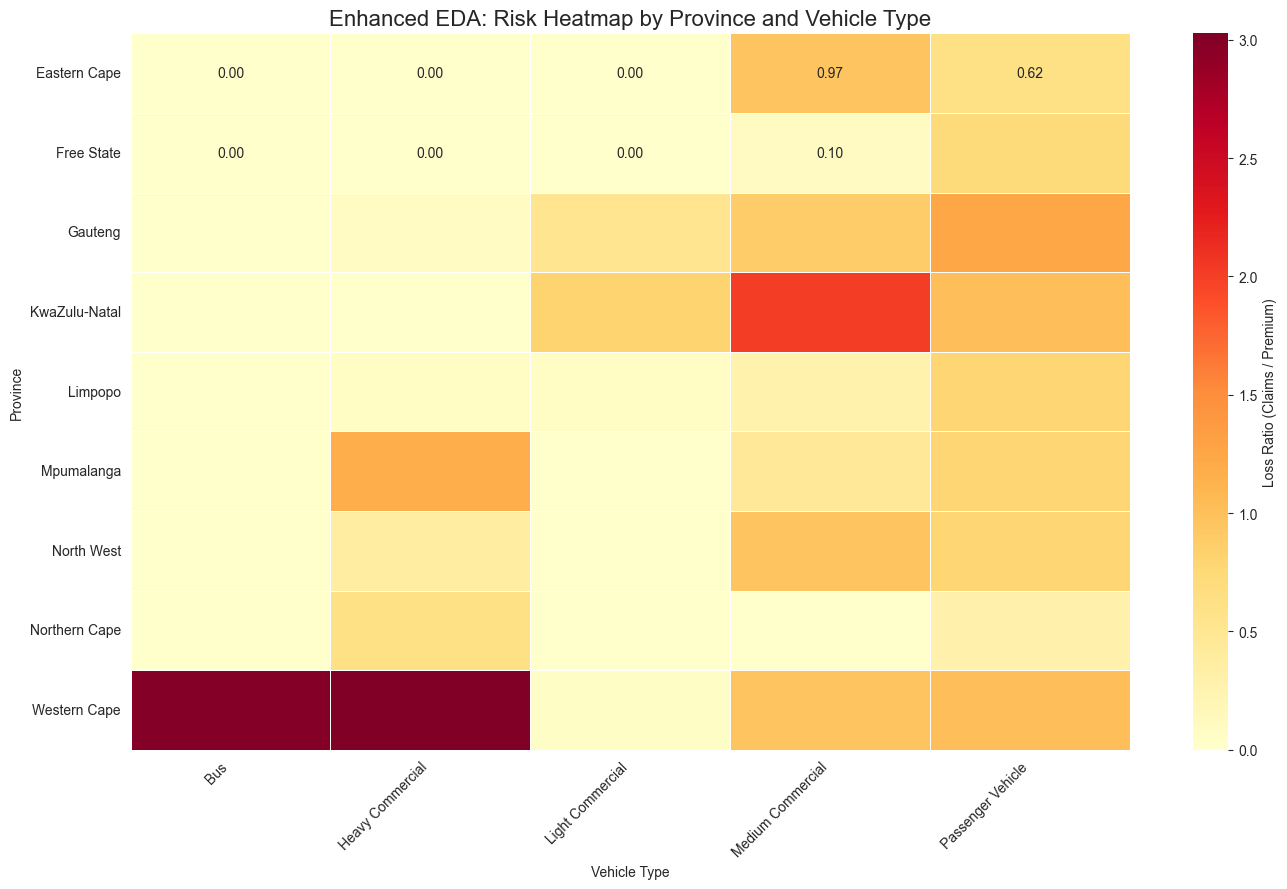

In [13]:
# 1. Create the aggregated pivot table
risk_pivot = df.pivot_table(
    index='Province',
    columns='VehicleType',
    values=['TotalClaims', 'TotalPremium'],
    aggfunc='sum'
)

# 2. Calculate the Loss Ratio for every (Province, VehicleType) cell
# The result of the division is a DataFrame with MultiIndex columns (VehicleType).
loss_ratio_df = risk_pivot['TotalClaims'] / risk_pivot['TotalPremium']

# 3. Create the new MultiIndex level and merge it back into the original pivot table.

# Step 3a: Create the new MultiIndex columns
# We create a MultiIndex that prepends 'Loss_Ratio' to the existing VehicleType columns
new_level = pd.MultiIndex.from_product([['Loss_Ratio'], loss_ratio_df.columns])
loss_ratio_df.columns = new_level

# Step 3b: Concatenate the new 'Loss_Ratio' DataFrame back to the original
risk_pivot = pd.concat([risk_pivot, loss_ratio_df], axis=1)

# 4. Extract only the Loss Ratio data for the heatmap
# Now we can safely select the top level 'Loss_Ratio'
loss_ratio_matrix = risk_pivot['Loss_Ratio'].fillna(0)

# 5. Plot the heatmap (Final Visualization)
plt.figure(figsize=(14, 9)) # Increased size for better readability
sns.heatmap(
    loss_ratio_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd", 
    linewidths=.5,
    cbar_kws={'label': 'Loss Ratio (Claims / Premium)'}
)
plt.title('Enhanced EDA: Risk Heatmap by Province and Vehicle Type', fontsize=16)
plt.ylabel('Province')
plt.xlabel('Vehicle Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Skewness and Log-Transformation


--- Skewness Metrics ---
TotalPremium Skewness: 138.60 (High Skew > 1)
Total Claims (Positive) Count: 2788
Positive TotalClaims Skewness: 3.85 (Expected: Very High Skew > 5)


c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


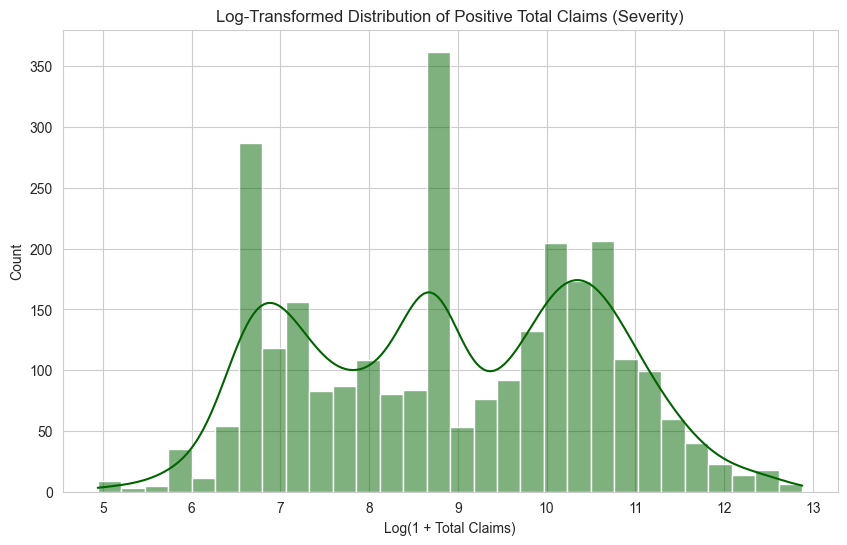

In [14]:
from scipy.stats import skew

# Calculate Skewness for TotalPremium and TotalClaims (for non-zero claims)
premium_skew = skew(df['TotalPremium'].dropna())
claims_positive = df[df['TotalClaims'] > 0]['TotalClaims'].dropna()

print(f"\n--- Skewness Metrics ---")
print(f"TotalPremium Skewness: {premium_skew:.2f} (High Skew > 1)")
print(f"Total Claims (Positive) Count: {len(claims_positive)}")

if len(claims_positive) > 50: # Ensure enough data points for a meaningful plot
    claims_skew = skew(claims_positive)
    print(f"Positive TotalClaims Skewness: {claims_skew:.2f} (Expected: Very High Skew > 5)")
    
    # Visualize using a log-transformed histogram to handle the extreme range
    plt.figure(figsize=(10, 6))
    sns.histplot(np.log1p(claims_positive), kde=True, bins=30, color='darkgreen')
    plt.title('Log-Transformed Distribution of Positive Total Claims (Severity)')
    plt.xlabel('Log(1 + Total Claims)')
    plt.show()

 # Missingness Trend

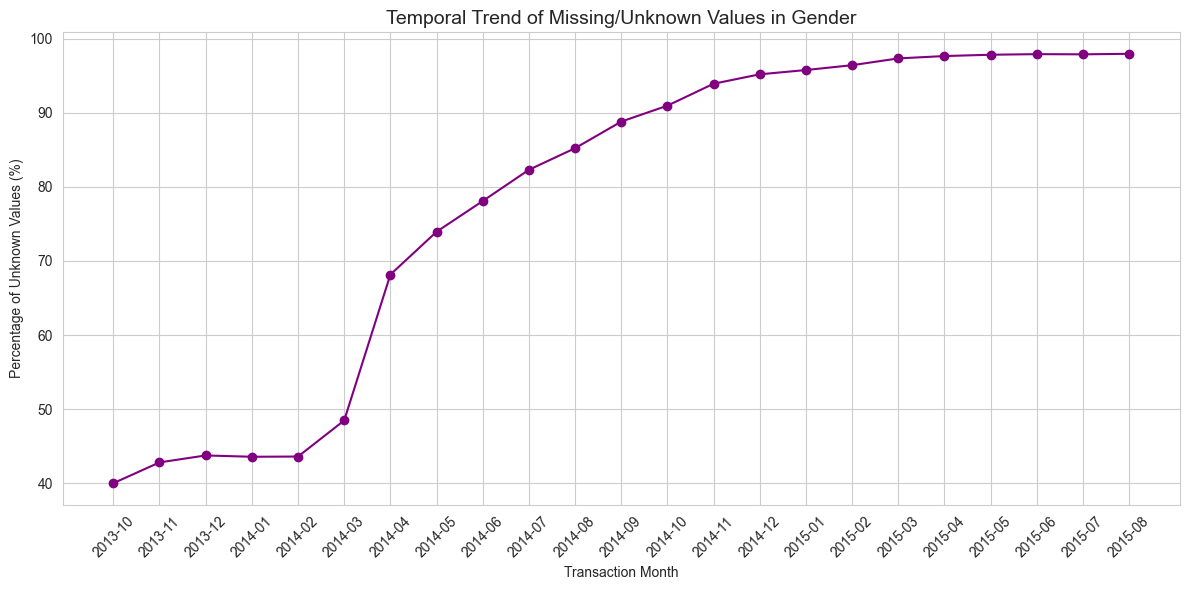

In [15]:
# Choose a feature that had some missing values in your initial check (e.g., Gender)
MISSING_COL = 'Gender' 

missing_trend = df.groupby('TransactionMonth')[MISSING_COL].apply(
    lambda x: (x == 'Unknown').mean() * 100 # Calculate percentage of 'Unknown'/'Not specified' per month
).reset_index(name='Missing_Percentage')

plt.figure(figsize=(12, 6))
plt.plot(missing_trend['TransactionMonth'].astype(str), missing_trend['Missing_Percentage'], marker='o', color='purple')
plt.title(f'Temporal Trend of Missing/Unknown Values in {MISSING_COL}', fontsize=14)
plt.xlabel('Transaction Month')
plt.ylabel('Percentage of Unknown Values (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


--- 1. Statistical Skewness Analysis ---
TotalPremium Skewness: 138.60
Positive TotalClaims Skewness (Severity): 3.85


c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


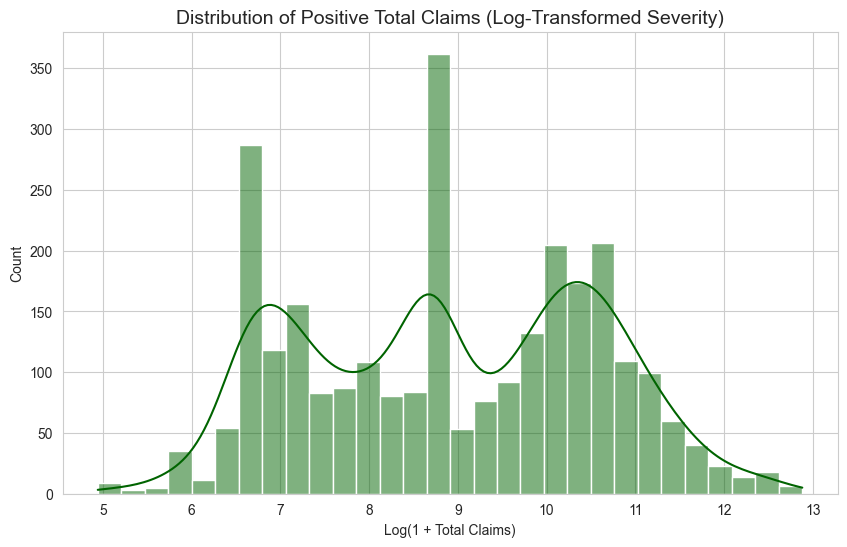

c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\Desktop\AI projects\insurance-risk-analytics\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: 

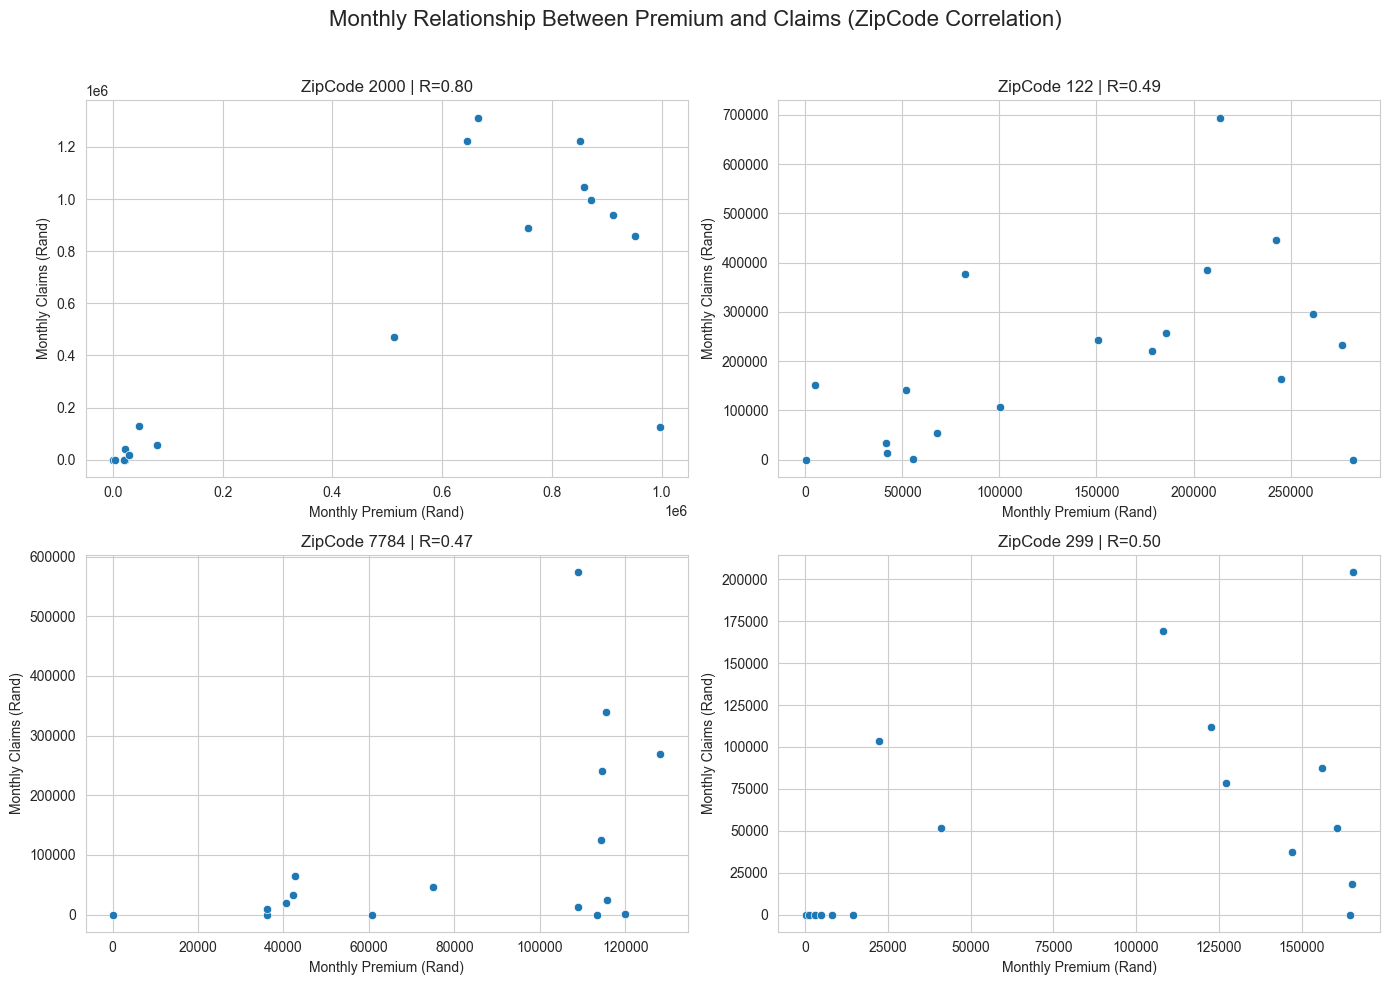

In [17]:


# Set environment for high-quality visualization
sns.set_style("whitegrid")

# -------------------------------------------------------------
# 1. Statistical Analysis: Testing for Skewness (Final Univariate/Stats)
# -------------------------------------------------------------

print("\n--- 1. Statistical Skewness Analysis ---")
# Filter for positive claims (we can only analyze the shape of non-zero claims)
claims_positive = df[df['TotalClaims'] > 0]['TotalClaims'].dropna()

premium_skew = skew(df['TotalPremium'].dropna())
print(f"TotalPremium Skewness: {premium_skew:.2f}")

if len(claims_positive) > 50: # Check for stability
    claims_skew = skew(claims_positive)
    print(f"Positive TotalClaims Skewness (Severity): {claims_skew:.2f}")
    
    # Justification for GLMs: Plot log-transformed histogram to confirm the heavy-tailed distribution
    plt.figure(figsize=(10, 6))
    # np.log1p(x) is equivalent to log(1 + x), handling zero values safely.
    sns.histplot(np.log1p(claims_positive), kde=True, bins=30, color='darkgreen')
    plt.title('Distribution of Positive Total Claims (Log-Transformed Severity)', fontsize=14)
    plt.xlabel('Log(1 + Total Claims)')
    plt.show() 
else:
    print(f"Insufficient positive claim data ({len(claims_positive)} found) to calculate stable skewness and plot log distribution.")


# -------------------------------------------------------------
# 2. ZipCode Correlation Analysis (Bivariate/Multivariate)
# -------------------------------------------------------------

# Aggregate data by PostalCode (ZipCode) and Month
zip_monthly_metrics = df.groupby(['PostalCode', df['TransactionMonth'].astype(str)]).agg(
    TotalPremium_Monthly=('TotalPremium', 'sum'),
    TotalClaims_Monthly=('TotalClaims', 'sum'),
    Claim_Count_Monthly=('TotalClaims', lambda x: (x > 0).sum())
).reset_index()

# Calculate Loss Ratio for monthly changes within each zipcode
zip_monthly_metrics['Loss_Ratio_Monthly'] = zip_monthly_metrics['TotalClaims_Monthly'] / zip_monthly_metrics['TotalPremium_Monthly']
zip_monthly_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)
zip_monthly_metrics.dropna(subset=['Loss_Ratio_Monthly'], inplace=True)

# Select high-volume zip codes for a meaningful correlation plot
top_zipcodes = df['PostalCode'].value_counts().head(5).index

plt.figure(figsize=(14, 10))
plt.suptitle('Monthly Relationship Between Premium and Claims (ZipCode Correlation)', fontsize=16)

# Create a scatter plot for top 4 zip codes showing the premium vs. claims relationship
for i, zipcode in enumerate(top_zipcodes[:4]):
    subset = zip_monthly_metrics[zip_monthly_metrics['PostalCode'] == zipcode]
    
    # Calculate Correlation (Association)
    correlation = subset['TotalPremium_Monthly'].corr(subset['TotalClaims_Monthly'])
    
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x='TotalPremium_Monthly', y='TotalClaims_Monthly', data=subset)
    plt.title(f'ZipCode {zipcode} | R={correlation:.2f}', fontsize=12)
    plt.xlabel('Monthly Premium (Rand)')
    plt.ylabel('Monthly Claims (Rand)')
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.show()